## Preprocessing

We begin by attaching the dataset and conducting an initial overview.

In [4]:
import pandas as pd
emotion = pd.read_csv("emotion.csv")
identification = pd.read_csv("data_identification.csv")
tweet = pd.read_json("tweets_DM.json", lines=True)

In [5]:
tweet.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


We observe that the `source` variable contains a substantial amount of information. We can extract and analyze specific elements from it to perform sentiment analysis.

In [6]:
tweet["_source"].head()

0    {'tweet': {'hashtags': ['Snapchat'], 'tweet_id...
1    {'tweet': {'hashtags': ['freepress', 'TrumpLeg...
2    {'tweet': {'hashtags': ['bibleverse'], 'tweet_...
3    {'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...
4    {'tweet': {'hashtags': [], 'tweet_id': '0x2de2...
Name: _source, dtype: object

In [7]:
tweetid = []
hashtags = []
text = []

for i in tweet["_source"]:
    tweetid.append(i["tweet"]["tweet_id"])
    hashtags.append(i["tweet"]["hashtags"])
    text.append(i["tweet"]["text"])
    
tweet["_tweet_id"] = tweetid
tweet["_text"] = text
tweet["_hashtags"] = hashtags

In [8]:
tweet = tweet.sort_values(by ="_tweet_id")
identification = identification.sort_values(by = "tweet_id")
emotion = emotion.sort_values(by = "tweet_id")

In [9]:
tweet = tweet.reset_index()
emotion = emotion.reset_index()
identification = identification.reset_index()
tweet["identify"] = identification["identification"]

In [10]:
train = []
test = []

tweet = tweet.drop(columns=["_source","_index","_type","_crawldate"])
group = tweet.groupby(["identify"])
train = group.get_group('train')
train = train.reset_index()
test = group.get_group('test')

In [11]:
train["eid"] = emotion["tweet_id"]
train["emotion"] = emotion["emotion"]
train = train.drop(columns=["eid","level_0","identify"])
test = test.drop(columns=["identify"]) # for submission

In [12]:
import pandas as pd

train_df = train.sample(frac=0.8, random_state=42)
test_df = train.drop(train_df.index)

# Display the shapes of the resulting sets
print("Training set shape:", train_df.shape)
print("Validation set shape:", test_df.shape)


Training set shape: (1164450, 6)
Validation set shape: (291113, 6)


In [13]:
train_df.to_pickle("train.pkl") 
test_df.to_pickle("test.pkl")
test.to_pickle("validation.pkl")

In [14]:
## load a pickle file
train_df = pd.read_pickle("train.pkl")
test_df = pd.read_pickle("test.pkl")
val_df = pd.read_pickle("validation.pkl")

In [15]:
train_df.groupby(['emotion']).count()['_text']

emotion
anger            31820
anticipation    199240
disgust         111132
fear             51101
joy             413268
sadness         154657
surprise         38969
trust           164263
Name: _text, dtype: int64

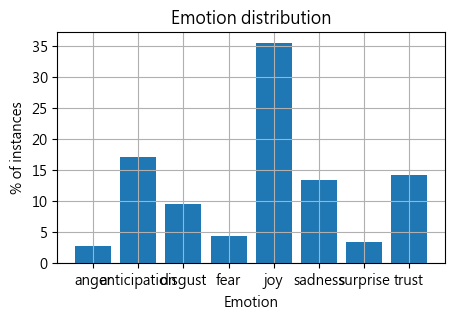

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['_text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

## Decision Tree

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
BOW_vectorizer = CountVectorizer() 

In [19]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['_text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['_text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['_text'])

In [20]:
# check the result
train_data_BOW_features

<1164450x675862 sparse matrix of type '<class 'numpy.int64'>'
	with 15081273 stored elements in Compressed Sparse Row format>

In [21]:
type(train_data_BOW_features)

scipy.sparse._csr.csr_matrix

In [22]:
train_data_BOW_features.shape

(1164450, 675862)

In [23]:
import nltk

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize, stop_words='english') 

# apply analyzer to training data
BOW_500.fit(train_df['_text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['_text'])

## check dimension
train_data_BOW_features_500.shape

c:\Users\Ying Tung\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1164450, 500)

In [24]:
train_data_BOW_features_500.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['comes', 'coming', 'content', 'cool', 'corinthians', 'country',
       'crazy', 'd', 'dad', 'damn'], dtype=object)

In [26]:
"😂" in feature_names_500

True

In [27]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['_text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['_text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (1164450, 500)
y_train.shape:  (1164450,)
X_test.shape:  (291113, 500)
y_test.shape:  (291113,)


In [28]:
#submit_data_BOW_features = BOW_vectorizer.transform(val_df['_text'])
val_test = BOW_500.transform(val_df['_text'])
val_test.shape

(411972, 500)

In [29]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'trust', 'disgust', 'fear', 'joy', 'disgust', 'disgust',
       'disgust', 'disgust', 'fear'], dtype=object)

In [30]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

training accuracy: 0.89
testing accuracy: 0.41


In [31]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.16      0.15      0.15      8047
anticipation       0.43      0.44      0.43     49695
     disgust       0.26      0.25      0.26     27969
        fear       0.26      0.22      0.24     12898
         joy       0.51      0.61      0.56    102749
     sadness       0.37      0.32      0.34     38780
    surprise       0.25      0.17      0.20      9760
       trust       0.34      0.27      0.30     41215

    accuracy                           0.41    291113
   macro avg       0.32      0.30      0.31    291113
weighted avg       0.40      0.41      0.41    291113



In [32]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[ 1182  1060  1042   325  2429  1135   211   663]
 [  917 21954  2736  1272 14525  3343   683  4265]
 [  989  3150  6957  1015  8157  4912   776  2013]
 [  365  1624  1168  2890  4308  1334   264   945]
 [ 1795 12444  5568  2745 62310  6588  1432  9867]
 [ 1247  4186  5202  1239 10796 12504   980  2626]
 [  286  1208  1173   403  2938  1330  1667   755]
 [  748  5787  2670  1093 16086  3070   632 11129]]


In [33]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

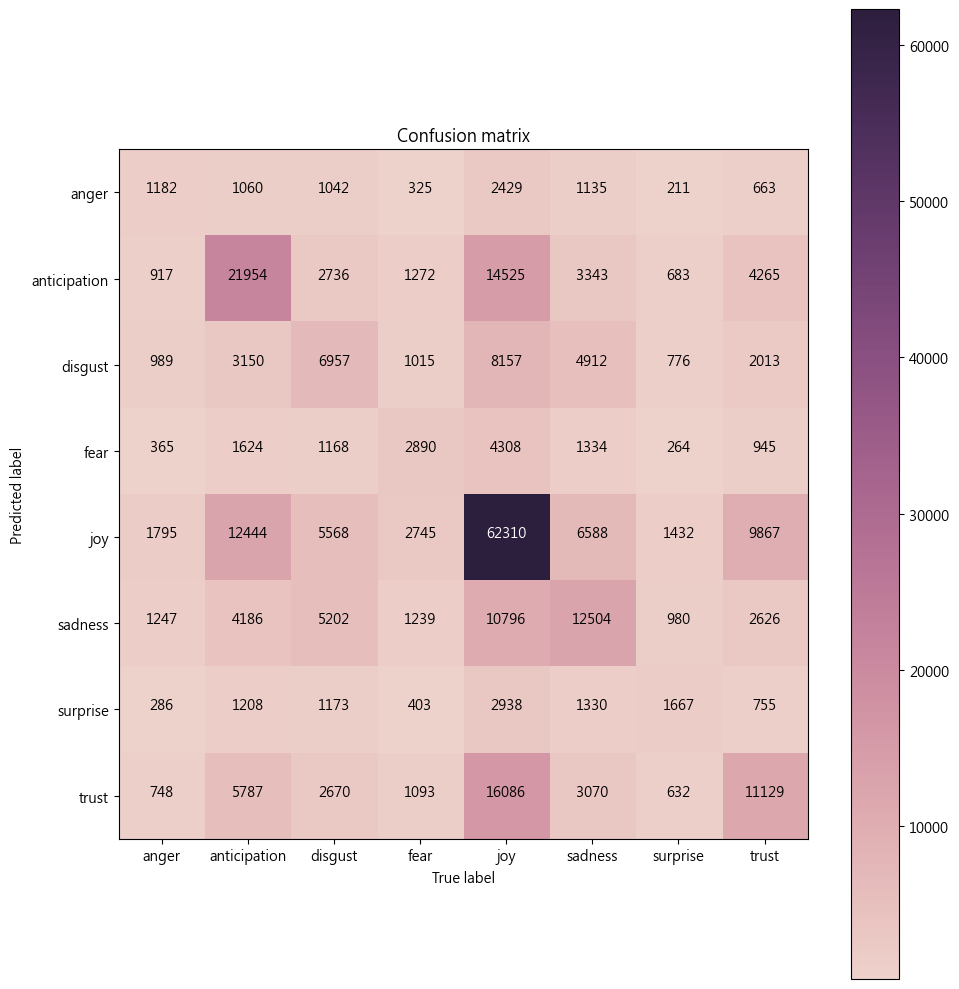

In [34]:
# plot your confusion matrix
my_tags = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

In [35]:
val_pred = DT_model.predict(val_test)
## so we get the pred result
val_pred[:10]

array(['disgust', 'sadness', 'trust', 'anticipation', 'disgust', 'trust',
       'sadness', 'joy', 'joy', 'disgust'], dtype=object)

In [36]:
submission = pd.DataFrame(val_pred)
submission = submission.rename(columns = {0:"emotion"})
submission.insert(0,"id",value =  test["_tweet_id"])

In [37]:
submission.to_csv("submission1.csv", index=False)

## XGBoost

XGBoost combines the power of gradient boosting, decision trees, regularization, and optimization techniques to create an accurate and efficient predictive model. 
Its ability to handle various types of data, deal with overfitting, and provide feature importance makes it widely applicable in diverse machine learning tasks.

In [114]:
from xgboost import XGBClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [124]:
xg_model = XGBClassifier(learning_rate=0.1, n_estimators=300,
                         max_depth = 6, subsample=0.8)

In [125]:
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [128]:
#y_test = le.fit_transform(y_test)
y_test_xgpred = xg_model.predict(X_test)
print(classification_report(y_test, y_test_xgpred))

              precision    recall  f1-score   support

           0       0.98      0.05      0.09      8047
           1       0.82      0.28      0.42     49695
           2       0.86      0.08      0.15     27969
           3       0.91      0.14      0.24     12898
           4       0.74      0.35      0.47    102749
           5       0.79      0.18      0.29     38780
           6       0.92      0.12      0.22      9760
           7       0.84      0.12      0.21     41215

   micro avg       0.78      0.23      0.36    291113
   macro avg       0.86      0.16      0.26    291113
weighted avg       0.81      0.23      0.34    291113
 samples avg       0.23      0.23      0.23    291113



c:\Users\Ying Tung\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Deep Learning

In [38]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['_text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['_text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)


X_train.shape:  (1164450, 500)
y_train.shape:  (1164450,)
X_test.shape:  (291113, 500)
y_test.shape:  (291113,)


In [39]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 970345          disgust
1145883             joy
468264          disgust
949718     anticipation
Name: emotion, dtype: object

y_train.shape:  (1164450,)
y_test.shape:  (291113,)


## After convert
y_train[0:4]:
 [[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]]

y_train.shape:  (1164450, 8)
y_test.shape:  (291113, 8)


In [40]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  8


In [41]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 softmax (Softmax)           (None, 8)                 0   

In [43]:
model.save_weights('my_checkpoint')

model.load_weights('my_checkpoint')
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))



9098/9098 - 7s - loss: 2.0331 - accuracy: 0.1874 - 7s/epoch - 759us/step
Restored model, accuracy: 18.74%


In [44]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

2275/2275 [==============================] - 4s 2ms/step


array([[0.09159299, 0.11871012, 0.11971378, 0.11068342, 0.1503534 ,
        0.15196584, 0.12831414, 0.12866634],
       [0.10351301, 0.11870361, 0.13345474, 0.12018498, 0.13362072,
        0.13324238, 0.12702978, 0.13025081],
       [0.07524496, 0.12204625, 0.15729111, 0.16654027, 0.12139968,
        0.12484193, 0.14044109, 0.0921947 ],
       [0.11311259, 0.13509893, 0.13157982, 0.11576502, 0.13105513,
        0.12344062, 0.12692581, 0.12302215],
       [0.09717535, 0.1208728 , 0.13695736, 0.1229568 , 0.12751964,
        0.14759743, 0.11785443, 0.12906623]], dtype=float32)

In [45]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['sadness', 'joy', 'fear', 'anticipation', 'sadness'], dtype=object)

In [46]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.19


In [47]:
val_result = model.predict(val_test, batch_size=128)
val_result[:5]

3219/3219 [==============================] - 10s 3ms/step


array([[0.09933084, 0.12538299, 0.12543838, 0.13304588, 0.13249797,
        0.13093412, 0.12644911, 0.12692074],
       [0.09213185, 0.12994325, 0.13208751, 0.10406114, 0.13086656,
        0.15204489, 0.13163263, 0.12723216],
       [0.10479428, 0.12836885, 0.15649435, 0.11510248, 0.11036792,
        0.12438496, 0.12876524, 0.13172188],
       [0.10214742, 0.12187585, 0.13268879, 0.12341825, 0.13280104,
        0.13622145, 0.12609798, 0.12474915],
       [0.09383536, 0.12650867, 0.10804126, 0.13446645, 0.14388435,
        0.1269546 , 0.13702652, 0.12928282]], dtype=float32)

In [48]:
val_result = label_decode(label_encoder, val_result)
val_result[:5]

array(['fear', 'sadness', 'disgust', 'sadness', 'joy'], dtype=object)

In [49]:
#test = test.reset_index()
submission2 = pd.DataFrame(val_result)
submission2 = submission2.rename(columns = {0:"emotion"})
submission2.insert(0,"id",value =  test["_tweet_id"])
submission2.to_csv("submission2.csv", index=False)

## BERT

In [50]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=8)  # Set num_labels to the number of sentiment classes

# Assuming your DataFrame has columns 'text' and 'sentiment'
X = train['_text'].tolist()
y = train['emotion'].tolist()

# Convert labels to numerical format (assuming labels are integers ranging from 0 to 7)
label_mapping = {label: i for i, label in enumerate(set(y))}
y = [label_mapping[label] for label in y]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing
train_inputs = tokenizer(X_train, return_tensors='pt', padding=True, truncation=True)
train_labels = torch.tensor(y_train)

val_inputs = tokenizer(X_val, return_tensors='pt', padding=True, truncation=True)
val_labels = torch.tensor(y_val)

# Fine-tune BERT model
optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

num_epochs = 5  # Adjust as needed

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
batch_size = 8  # or any smaller value
train_inputs = tokenizer(X_train, return_tensors='pt', padding=True, truncation=True)
train_labels = torch.tensor(y_train)
train_data = torch.utils.data.TensorDataset(train_inputs['input_ids'], train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
gradient_accumulation_steps = 4  # or any desired value
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs, labels=labels)
        loss = outputs.loss / gradient_accumulation_steps
        loss.backward()
        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()


# Model evaluation
model.eval()
with torch.no_grad():
    val_outputs = model(**val_inputs, labels=val_labels)
    val_loss = val_outputs.loss
    predicted_labels = torch.argmax(val_outputs.logits, dim=1)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_val, predicted_labels.numpy())
print(f'Validation Accuracy: {accuracy:.4f}')

## Future Work

In this Kaggle competition, achieving a high score is predominantly associated with the utilization of deep learning. However, in the XGBoost method, continually fine-tuning the parameters could potentially yield positive results.
In those methods, I did not take 'hashtags' into consideration. Perhaps this variable contains valuable information that could lead to better results.
Additionally, I intended to explore the application of LLM to train the dataset. Unfortunately, this endeavor was hindered by hardware restrictions, prompting me to consider alternative strategies, for instance optimizing the model architecture or leveraging cloud-based resources, to overcome these hardware limitations and proceed with the LLM approach for training the dataset.